In [7]:
# for bert 
from transformers import DistilBertTokenizerFast, DistilBertModel

# for data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# for interactive data visualization
import altair as alt
import matplotlib

# for connecting to a database 
import os
from datetime import datetime
import psycopg2 as pg
import pandas.io.sql as psql

In [2]:
#pubmed_data = "https://raw.githubusercontent.com/brandonleekramer/diversity/master/data/bert_data/diversity_test_abstracts.csv"
#pubmed_data = pd.read_csv(pubmed_data, encoding='utf-8')

# connect to the database, download data 
connection = pg.connect(host = 'postgis1', database = 'sdad', 
                        user = os.environ.get('db_user'), 
                        password = os.environ.get('db_pwd'))

pubmed_1990s = '''SELECT abstract, year, publication, soc_div_terms, diversity, soc_diversity 
                FROM pubmed_2021.all_diversity_abstracts WHERE year BETWEEN 1990 AND 1999'''
pubmed_2000s = '''SELECT abstract, year, publication, soc_div_terms, diversity, soc_diversity 
                FROM pubmed_2021.all_diversity_abstracts WHERE year BETWEEN 2000 AND 2009'''
pubmed_2010s = '''SELECT abstract, year, publication, soc_div_terms, diversity, soc_diversity 
                FROM pubmed_2021.all_diversity_abstracts WHERE year BETWEEN 2010 AND 2019'''

pubmed_1990s = pd.read_sql_query(pubmed_1990s, con=connection)
pubmed_2000s = pd.read_sql_query(pubmed_2000s, con=connection)
pubmed_2010s = pd.read_sql_query(pubmed_2010s, con=connection)

pubmed_1990s['time_period'] = ['1990s'] * len(pubmed_1990s)
pubmed_2000s['time_period'] = ['2000s'] * len(pubmed_2000s)
pubmed_2010s['time_period'] = ['2010s'] * len(pubmed_2010s)

pubmed_data = pd.concat([pubmed_1990s, pubmed_2000s, pubmed_2010s], sort=False)
pubmed_data.head()

,abstract,year,publication,soc_div_terms,diversity,soc_diversity,time_period
0,"African-Americans have an unexplained increased incidence and mortality from stroke compared with whites, and little is known about stroke in Hispanics. To investigate cross-sectional differences ...",1995,Neurology,126.0,0.0,0.0,1990s
1,"OBJECTIVE:\nDetermination of skeletal or bone age is often used in pediatrics and orthopedics. The most commonly used bone age standards in the United States, those published by Greulich and Pyle,...",1996,AJR. American journal of roentgenology,126.0,1.0,1.0,1990s
2,"OBJECTIVE:\nAlthough US blacks are known to have an excess stroke mortality compared with US whites, little is known about the stroke burden of the Hispanic white population. This report will prov...",1994,Stroke,112.0,0.0,0.0,1990s
3,"BACKGROUND:\nCurrently recognized risk factors for coronary artery disease have been identified primarily from investigations of white populations. In this investigation, we estimated mortality ra...",1993,The New England journal of medicine,105.0,0.0,0.0,1990s
4,"Ethnic and gender differences in bone mineral acquisition were examined in a longitudinal study of 423 healthy Asian, black, Hispanic, and white males and females (aged 9-25 yr). Bone mass of the ...",1999,The Journal of clinical endocrinology and metabolism,104.0,0.0,0.0,1990s


In [3]:
print('1990s:', len(pubmed_1990s), '- 2000s:', len(pubmed_2000s), '- 2010s:', len(pubmed_2010s))

1990s: 135594 - 2000s: 223295 - 2010s: 425015


<AxesSubplot:>

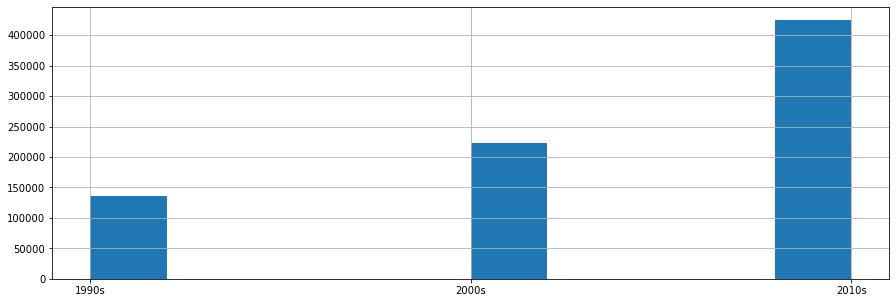

In [4]:
pubmed_data['time_period'].sort_values().hist(figsize=(15, 5))

In [5]:
pubmed_texts = pubmed_data['abstract'].tolist()
pubmed_texts[0]

'African-Americans have an unexplained increased incidence and mortality from stroke compared with whites, and little is known about stroke in Hispanics. To investigate cross-sectional differences in sociodemographic and stroke risk factors, we prospectively evaluated 430 patients hospitalized for acute ischemic stroke (black 35%. Hispanic 46%, white 19%) over the age of 39 from Northern Manhattan. Blacks and Hispanics were younger than whites (mean ages, blacks 70, Hispanics 67, whites 80; p < 0.001) and were more likely to have less than 12 years of education than whites. Hypertension was more prevalent in blacks and Hispanics with stroke than whites (blacks 76%, Hispanics 79%, whites 63%; p < 0.05) and was often untreated in blacks. Left ventricular hypertrophy by ECG was more frequent in blacks (blacks 20%, whites 9%; p = 0.02). History of cardiac disease (atrial fibrillation, myocardial infarction, angina, and congestive heart failure) was less prevalent in both blacks and Hispani

In [6]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenized_texts = tokenizer(pubmed_texts, truncation=True, padding=True, return_tensors="pt")
' '.join(tokenized_texts[0].tokens)

'[CLS] african - americans have an une ##x ##pl ##aine ##d increased incidence and mortality from stroke compared with whites , and little is known about stroke in hispanic ##s . to investigate cross - sectional differences in socio ##de ##mo ##graphic and stroke risk factors , we prospective ##ly evaluated 430 patients hospitalized for acute is ##che ##mic stroke ( black 35 % . hispanic 46 % , white 19 % ) over the age of 39 from northern manhattan . blacks and hispanic ##s were younger than whites ( mean ages , blacks 70 , hispanic ##s 67 , whites 80 ; p < 0 . 001 ) and were more likely to have less than 12 years of education than whites . hyper ##tension was more prevalent in blacks and hispanic ##s with stroke than whites ( blacks 76 % , hispanic ##s 79 % , whites 63 % ; p < 0 . 05 ) and was often un ##tre ##ated in blacks . left vent ##ric ##ular hyper ##tro ##phy by ec ##g was more frequent in blacks ( blacks 20 % , whites 9 % ; p = 0 . 02 ) . history of cardiac disease ( at ##ri

In [8]:
from transformers import DistilBertModel
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print("Started at:", datetime.now().time())

# List of vocabulary word IDs for all the words in each document (aka each abstract)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each abstract)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one abstract at a time
first_document = 0

for i, abstract in enumerate(pubmed_texts):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(abstract, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())

print("Finished at:", datetime.now().time())

Started at: 08:09:15.767773


In [8]:
len(doc_word_ids), len(doc_word_vectors)

(3000, 3000)

In [9]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 1996,  6864, 27710,  5250, 14988,  1006, 10439,  1007,  1997,
        21901,  1005,  1055,  4295,  2001,  2179,  2000, 14187,  2938,
         4648,  6321,  1006,  1047,  2094,  1027,  3438, 13221,  1007,
         2000, 28086,  8713, 14556,  4167,  4469, 16882,  8185,  1006,
        14925,  2213,  1007,  1012,  1996,  8031,  1997, 10439,  2000,
        14925,  2213,  2001,  2025, 26402,  2098,  2011,  2184, 12702,
        13113,  2015,  1013, 19875,  2002, 19362,  2378,  2030,  2002,
        28689,  2078, 26754,  1012,  2174,  1010,  3653,  7913,  4017,
         3672,  1997,  4442,  2007,  1015,  3461,  1018,  1011, 25003,
        25438, 13348,  7512,  8516,  1011,  8247,  1011,  1040,  1011,
         1060,  8516, 20049,  3207,  1010,  2019, 24054,  1997,  4013,
         2618,  8649,  2135,  9336, 16012,  6508,  3372, 24124,  1010,
         4359,  1996,  2193,  1997, 10439,  8031,  4573,  2006,  1996,
        14925,  2213,  2011,  3770,  1003,  1012,  1996,  8031,  1997,
      

In [10]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

In [11]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

In [12]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

In [13]:
get_word_positions(["race"])

array([ 48778, 260493, 323538, 324193, 324301, 324383, 324589, 398347,
       498550, 498653, 499171, 557426, 557485, 557691, 621932, 622113,
       622186, 622367, 683648, 728892, 748278, 748389, 809726, 867308,
       867818, 892601, 892687, 897517, 897639])

In [14]:
word_positions = get_word_positions(["race"])

In [15]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

In [16]:
word_positions = get_word_positions(["race"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

48778 race
260493 race
323538 race
324193 race
324301 race
324383 race
324589 race
398347 race
498550 race
498653 race
499171 race
557426 race
557485 race
557691 race
621932 race
622113 race
622186 race
622367 race
683648 race
728892 race
748278 race
748389 race
809726 race
867308 race
867818 race
892601 race
892687 race
897517 race
897639 race


In [17]:
word_positions = get_word_positions(["race"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

48778 ##18 is the race ##mic mixture of
260493 to sex , race , and age
323538 the influence of race on stage st
324193 . age , race , serum prostate
324301 significant differences by race in terms of
324383 . however , race appears to have
324589 ranges for each race . results :
398347 inflammation varied by race and could account
498550 demographic data including race and family income
498653 ##rat ##ified by race and gender .
499171 , percent minority race , or percent
557426 the effect of race on breast car
557485 were compared by race category . results
557691 study show that race is an independent
621932 . methods : race - specific cox
622113 , regardless of race and after adjustment
622186 . methods : race - specific cox
622367 , regardless of race and after adjustment
683648 the influence of race and ethnicity on
728892 designed to examine race and gender differences
748278 ##rano ##lo ##l race ##mate ( rs
748389 than that of race ##mates according to
809726 , gender , race / et

In [23]:
import re
from IPython.display import Markdown, display

def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

def print_md(string):
    display(Markdown(string))

In [24]:
word_positions = get_word_positions(["race"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 48778:  of 200. sl 84. 0418 is the racemic mixture of two enantiomers, sl <br>

<br> 260493:  neighborhood, matched with the victim according to sex, **race**, and age range. crude and adjusted odds ratios <br>

<br> 323538:  of men. objective: we assess the influence of **race** on stage stratified cause specific survival of men <br>

<br> 324193:  center between january 1990 and november 1998. age, **race**, serum prostate specific antigen ( psa ), <br>

<br> 324301:  ). there were no statistically significant differences by **race** in terms of patient age, prostate volume, clinical <br>

<br> 324383:  a density than similarly treated white men. however, **race** appears to have no independent impact on pathological findings <br>

<br> 324589:  defined by age specific psa reference ranges for each **race**. results: disease stage and grade were similar or <br>

<br> 398347:  volume. we determined whether prostatic inflammation varied by **race** and could account for the racial difference in psa <br>

<br> 498550:  survey of youth were studied. comprehensive demographic data including **race** and family income were available in 97 % of the <br>

<br> 498653:  and alcohol consumption. data were stratified by **race** and gender. the data were weighted to reflect a <br>

<br> 499171:  differences between groups in mean parent age, percent minority **race**, or percent public aid. eighty-seven percent <br>

<br> 557426:  and end results program and to examine the effect of **race** on breast carcinoma survival. methods: subjects <br>

<br> 557485:  opausal status, and survival were compared by **race** category. results: african american women diagnosed with breast <br>

<br> 557691:  conclusions: the results of the current study show that **race** is an independent predictor of survival from breast car <br>

<br> 621932:  participants in the alameda county study. methods: **race**-specific cox proportional hazard models estimated diabetes risk associated <br>

<br> 622113:  sep measures in determining risk of diabetes, regardless of **race** and after adjustment for factors that may confound <br>

<br> 622186:  participants in the alameda county study. methods: **race**-specific cox proportional hazard models estimated diabetes risk associated <br>

<br> 622367:  sep measures in determining risk of diabetes, regardless of **race** and after adjustment for factors that may confound <br>

<br> 683648:  defined using a visual scoring method, the influence of **race** and ethnicity on hirsutism, and the <br>

<br> 728892:  m arrest. the study was specifically designed to examine **race** and gender differences in risk factors. our data indicated <br>

<br> 748278:  human skin permeability of propranolol racemate ( rs-pr ) or s-en <br>

<br> 748389:  iomers resulted about twofold higher than that of racemates according to their lower melting temperatures with the exception <br>

<br> 809726:  and total cost were measured. age, gender, **race** / ethnicity, trauma status, acute physiology and chronic <br>

<br> 867308:  equal number of mortality, age, gender, and **race**-matched patients also admitted to the intensive care unit <br>

<br> 867818:  equal number of mortality, age, gender, and **race**-matched patients also admitted to the intensive care unit <br>

<br> 892601:  were reported for the solid-state nature of the racemic species of the pharmaceutical relevant compound propranolo <br>

<br> 892687:  were used as analytical methods. the type of the racemic species, the presence and extent of partial solid <br>

<br> 897517:  specific incidence rates were stratified by sex and **race** and supplemented with age-period-cohort models <br>

<br> 897639:  to-female incidence rate ratios did not differ by **race**, but were 4. 2 for pediatric ( 0 <br>

In [25]:
word_positions = get_word_positions(["race"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

In [26]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["race"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

In [27]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.144390,0.381907,"of 200. sl 84. 0418 is the racemic mixture of two enantiomers, sl","of 200 . sl 84 . 04 ##18 is the race ##mic mixture of two en ##ant ##iom ##ers , sl"
1,-0.193367,-0.049282,"neighborhood, matched with the victim according to sex, **race**, and age range. crude and adjusted odds ratios","neighborhood , matched with the victim according to sex , race , and age range . crude and adjusted odds ratios"
2,-0.198144,-0.082837,of men. objective: we assess the influence of **race** on stage stratified cause specific survival of men,of men . objective : we assess the influence of race on stage st ##rat ##ified cause specific survival of men
3,-0.190234,-0.043748,"center between january 1990 and november 1998. age, **race**, serum prostate specific antigen ( psa ),","center between january 1990 and november 1998 . age , race , serum prostate specific antigen ( ps ##a ) ,"
4,-0.194124,-0.101297,"). there were no statistically significant differences by **race** in terms of patient age, prostate volume, clinical",") . there were no statistical ##ly significant differences by race in terms of patient age , prostate volume , clinical"


In [28]:
# Tokenize all the poems
tokenized_abstracts = tokenizer(pubmed_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_abstracts = []
for i in range(len(tokenized_abstracts['input_ids'])):
  all_tokenized_abstracts.append(' '.join(tokenized_abstracts[i].tokens))

# Add them to the original DataFrame
pubmed_data['tokens'] = all_tokenized_abstracts

In [31]:
def find_original_abstract(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if pubmed_data['tokens'].str.contains(text, regex=False).any() == True :
    row = pubmed_data[pubmed_data['tokens'].str.contains(text, regex=False)].values[0]
    abstract, year, publication, period = row[2], row[1], row[3], row[6]
    return abstract, year, publication, period
  else:
    return None, None, None, None

In [33]:
df[['abstract', 'year', 'publication', 'period']] = df.apply(find_original_abstract, axis='columns', result_type='expand')
df.head()

,x,y,context,tokens,abstract,year,publication,period
0,-0.144390,0.381907,"of 200. sl 84. 0418 is the racemic mixture of two enantiomers, sl","of 200 . sl 84 . 04 ##18 is the race ##mic mixture of two en ##ant ##iom ##ers , sl","One novel, potent and selective alpha-2 adrenoceptor antagonist is 2-(4,5-dihydro-1H-imidazol-2-yl)-1,2,4,5-tetrahydro-2- propylpyrrolo[3,2,1-hi]-indole hydrochloride (SL 84.0418). It inhibits wit...",1992,The Journal of pharmacology and experimental therapeutics,1990s
1,-0.193367,-0.049282,"neighborhood, matched with the victim according to sex, **race**, and age range. crude and adjusted odds ratios","neighborhood , matched with the victim according to sex , race , and age range . crude and adjusted odds ratios","BACKGROUND:\nIt has been suggested that limiting access to firearms could prevent many suicides, but this belief is controversial. To assess the strength of the association between the availabilit...",1992,The New England journal of medicine,1990s
2,-0.198144,-0.082837,of men. objective: we assess the influence of **race** on stage stratified cause specific survival of men,of men . objective : we assess the influence of race on stage st ##rat ##ified cause specific survival of men,"OBJECTIVE:\nWe assess the influence of race on stage stratified cause specific survival of men with prostate cancer, and Gleason score, age at diagnosis and treatment on potential racial differenc...",2000,The Journal of urology,2000s
3,-0.190234,-0.043748,"center between january 1990 and november 1998. age, **race**, serum prostate specific antigen ( psa ),","center between january 1990 and november 1998 . age , race , serum prostate specific antigen ( ps ##a ) ,",OBJECTIVE:\nThe reported incidence and mortality of prostate cancer are higher among black than white men. Reasons for the disproportionate racial incidence of this disease are not known but most ...,2000,The Journal of urology,2000s
4,-0.194124,-0.101297,"). there were no statistically significant differences by **race** in terms of patient age, prostate volume, clinical",") . there were no statistical ##ly significant differences by race in terms of patient age , prostate volume , clinical",OBJECTIVE:\nThe reported incidence and mortality of prostate cancer are higher among black than white men. Reasons for the disproportionate racial incidence of this disease are not known but most ...,2000,The Journal of urology,2000s


In [34]:
alt.Chart(df,title="Word Similarity: Diversity").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    #href="link",
    # The categories that show up in the hover tooltip
    tooltip=['abstract', 'year', 'publication', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [40]:
# List of keywords that you want to compare
keywords = ['diverse', 'diversity', 'race', 'ethnicity']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['abstract', 'year', 'publication', 'period']] = df.apply(find_original_abstract, axis='columns', result_type='expand')

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    #href="link",
    tooltip=['abstract', 'year', 'publication', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [42]:
# List of keywords that you want to compare
keywords = ['diverse', 'diversity', 'race', 'ethnicity']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['abstract', 'year', 'publication', 'period']] = df.apply(find_original_abstract, axis='columns', result_type='expand')

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    #href="link",
    tooltip=['abstract', 'year', 'publication', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

References 

https://colab.research.google.com/drive/1DjtrD_MMW_Ezto0Q4zUvjT0IxKZg-rIt?usp=sharing#scrollTo=rYa_KDUTSprJ

https://colab.research.google.com/drive/1r_eoi8CMea_a3YjWC1M4EmTqKMGVMbzQ?usp=sharing#scrollTo=zrau9RGwYic8

https://colab.research.google.com/drive/19jDqa5D5XfxPU6NQef17BC07xQdRnaKU?usp=sharing#scrollTo=u9-iSYQPefVg